# Segmentação de Imagem

Este tutorial concentra-se na tarefa de segmentação de imagens, usando uma <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external"> U-Net modificada </a>

## O que é segmentação de imagem?
Até agora, você viu a classificação de imagens, em que a tarefa da rede é atribuir um rótulo ou classe a uma imagem de entrada. No entanto, suponha que você queira saber onde um objeto está localizado na imagem, a forma desse objeto, qual pixel pertence a qual objeto etc. Nesse caso, você desejará segmentar a imagem, ou seja, para cada pixel da imagem é dado um rótulo. Assim, a tarefa da segmentação de imagens é treinar uma rede neural para produzir uma máscara da imagem em pixels. Isso ajuda a entender a imagem em um nível muito mais baixo, isto é, o nível de pixel. A segmentação de imagens tem muitas aplicações em imagens médicas, carros autônomos e imagens de satélite, para citar alguns.

O conjunto de dados que será usado para este tutorial é as moedas com mascara Cada pixel recebe uma das categorias:

* Classe 0: Pixel pertencente ao fundo
* Classe 1: Pixel na fronteira a moeda


In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ax_sx79v
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ax_sx79v
  Created wheel for tensorflow-examples: filename=tensorflow_examples-dc0ed6edab3110744a6371d914a79fe3048fc542_-py3-none-any.whl size=268213 sha256=a444c1ab44bd42f5eb960f86ce87c9e44c513cdf5f8aa102c68364be1d9b4059
  Stored in directory: /tmp/pip-ephem-wheel-cache-tesjhh_m/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
from skimage.transform import resize


## Baixar o conjunto de dados 



In [4]:
!wget https://www.inf.ufpr.br/aghochuli/coins_and_masks.zip -O coins_and_masks.zip
!unzip -qo coins_and_masks.zip

--2021-11-02 18:55:18--  https://www.inf.ufpr.br/aghochuli/coins_and_masks.zip
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17867526 (17M) [application/zip]
Saving to: ‘coins_and_masks.zip’

coins_and_masks.zip 100%[===================>]  17.04M  8.35MB/s    in 2.0s    

2021-11-02 18:55:21 (8.35 MB/s) - ‘coins_and_masks.zip’ saved [17867526/17867526]



In [5]:
#Listo todos paths das imagens e mascaras
import glob,random
import numpy as np
import cv2

val_samples=200
imgs_paths = glob.glob('coins_and_masks/images/*.png')
print(imgs_paths[:3])
masks_paths = glob.glob('coins_and_masks/masks/*.png')
print(masks_paths[:3])

t = list(zip(imgs_paths,masks_paths))
random.shuffle(t)
imgs_paths,masks_paths = zip(*t)

['coins_and_masks/images/5_1477290396.png', 'coins_and_masks/images/50_1477282512.png', 'coins_and_masks/images/5_1477289970.png']
['coins_and_masks/masks/5_1477290396.png', 'coins_and_masks/masks/50_1477282512.png', 'coins_and_masks/masks/5_1477289970.png']


In [6]:
#defino a funcao de carregamento dos dados
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class MyDataSetLoader(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)            
            img = np.asarray(img)
            img = img[...,::-1] #bgr2rgb
            x[j] = img/255.
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.asarray(img)
            y[j] = np.expand_dims(img, 2)/255.

            
            
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
            
        return x, y

In [7]:
#Instancio as bases de train e val

train_input_img_paths = imgs_paths[:-val_samples]
train_target_img_paths = masks_paths[:-val_samples]
val_input_img_paths = imgs_paths[-val_samples:]
val_target_img_paths = masks_paths[-val_samples:]
BATCH_SIZE = 32

# Instantiate data Sequences for each split
train_gen = MyDataSetLoader(BATCH_SIZE, (128,128), train_input_img_paths, train_target_img_paths)
val_gen = MyDataSetLoader(BATCH_SIZE, (128,128), val_input_img_paths, val_target_img_paths)



In [8]:
TRAIN_LENGTH = len(train_input_img_paths)
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

Vamos dar uma olhada em um exemplo de imagem e sua máscara correspondente no conjunto de dados.

In [9]:
#Funcao para mostrar a imagem e sua mascara
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(32, 128, 128, 3) (32, 128, 128, 1)
[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07843138 0.08235294 0.08627451 0.09019608 0.09411765 0.09803922
 0.10588235 0.11372549 0.11764706 0.12156863 0.1254902  0.12941177
 0.13333334 0.13725491 0.14117648 0.14509805 0.14901961 0.15294118
 0.16470589 0.17254902 0.1764706  0.18039216 0.18431373 0.1882353
 0.19215687 0.19607843 0.2        0.20392157 0.20784314 0.21176471
 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255 0.23529412
 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198 0.25882354
 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314  0.28235295
 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608  0.30588236
 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902  0.32941177
 0.33333334 0.3372549  0.34117648 0.34509805 0.34901962 0.3529412
 0.35686275 0.36078432 0.364

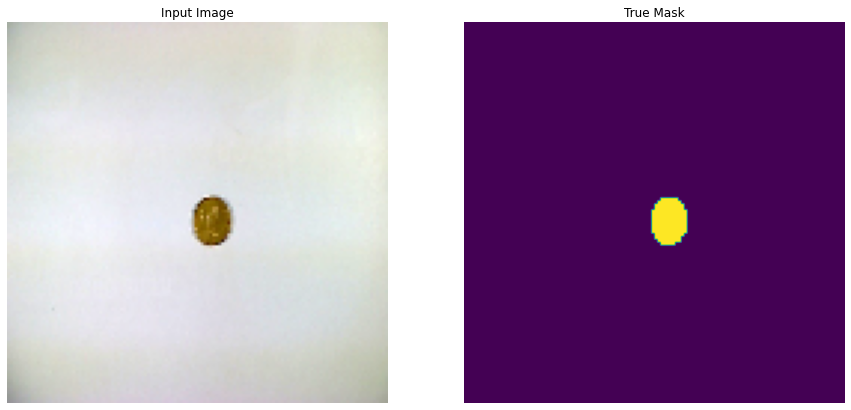

In [10]:
#Exemplo de como pedir uma imagem ao dataset
image, mask = train_gen.__getitem__(0)

i = random.randint(0,len(image))

print(image.shape,mask.shape) # verificamos se a imagem e a mascara tem as mesmas dimensoes
print(np.unique(image[i]))
print(np.unique(mask[i])) # verificamos se as mascaras sao binarias

display([image[i], mask[i]])

## Definir o modelo
O modelo usado aqui é uma U-Net modificada. Um U-Net consiste em um codificador (downsampler) e decodificador (upsampler). Para aprender características robustas e reduzir o número de parâmetros treináveis, um modelo pré-treinado pode ser usado como codificador. Portanto, o codificador para esta tarefa será um modelo MobileNetV2 pré-treinado, cujas saídas intermediárias serão usadas e o decodificador será o bloco de amostra superior já implementado no TensorFlow Examples no [tutorial Pix2pix] (https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py).

O motivo da saída de três canais é porque existem três rótulos possíveis para cada pixel. Pense nisso como multi-classificação, onde cada pixel está sendo classificado em três classes.

In [11]:
OUTPUT_CHANNELS = 2 #//classes

Como mencionado, o codificador será um modelo MobileNetV2 pré-treinado, preparado e pronto para uso em [tf.keras.applications] (https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). O codificador consiste em saídas específicas de camadas intermediárias no modelo. Observe que o codificador não será treinado durante o processo de treinamento.

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use as ativações dessas camadas
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Crie o modelo de extração de características
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


O decodificador/upsampler é simplesmente uma série de blocos de upsample implementados nos exemplos do TensorFlow.

In [13]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [14]:
def unet_model(output_channels):

    # Esta é a última camada do modelo
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='softmax')  #64x64 -> 128x128

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling através do modelo
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling e estabelecimento das conexões de salto
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Treine o modelo
Agora, tudo o que resta a fazer é compilar e treinar o modelo. A perda que está sendo usada aqui é loss.sparse_categorical_crossentropy. O motivo para usar essa função de perda é porque a rede está tentando atribuir a cada pixel um rótulo, assim como a previsão de várias classes. Na verdadeira máscara de segmentação, cada pixel tem um {0,1}. A rede aqui está emitindo três canais. Essencialmente, cada canal está tentando aprender a prever uma classe, e loss.sparse_categorical_crossentropy é a perda recomendada para esse cenário. Usando a saída da rede, o rótulo atribuído ao pixel é o canal com o valor mais alto. É isso que a função create_mask está fazendo.

In [15]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Dê uma olhada rápida na arquitetura do modelo resultante:

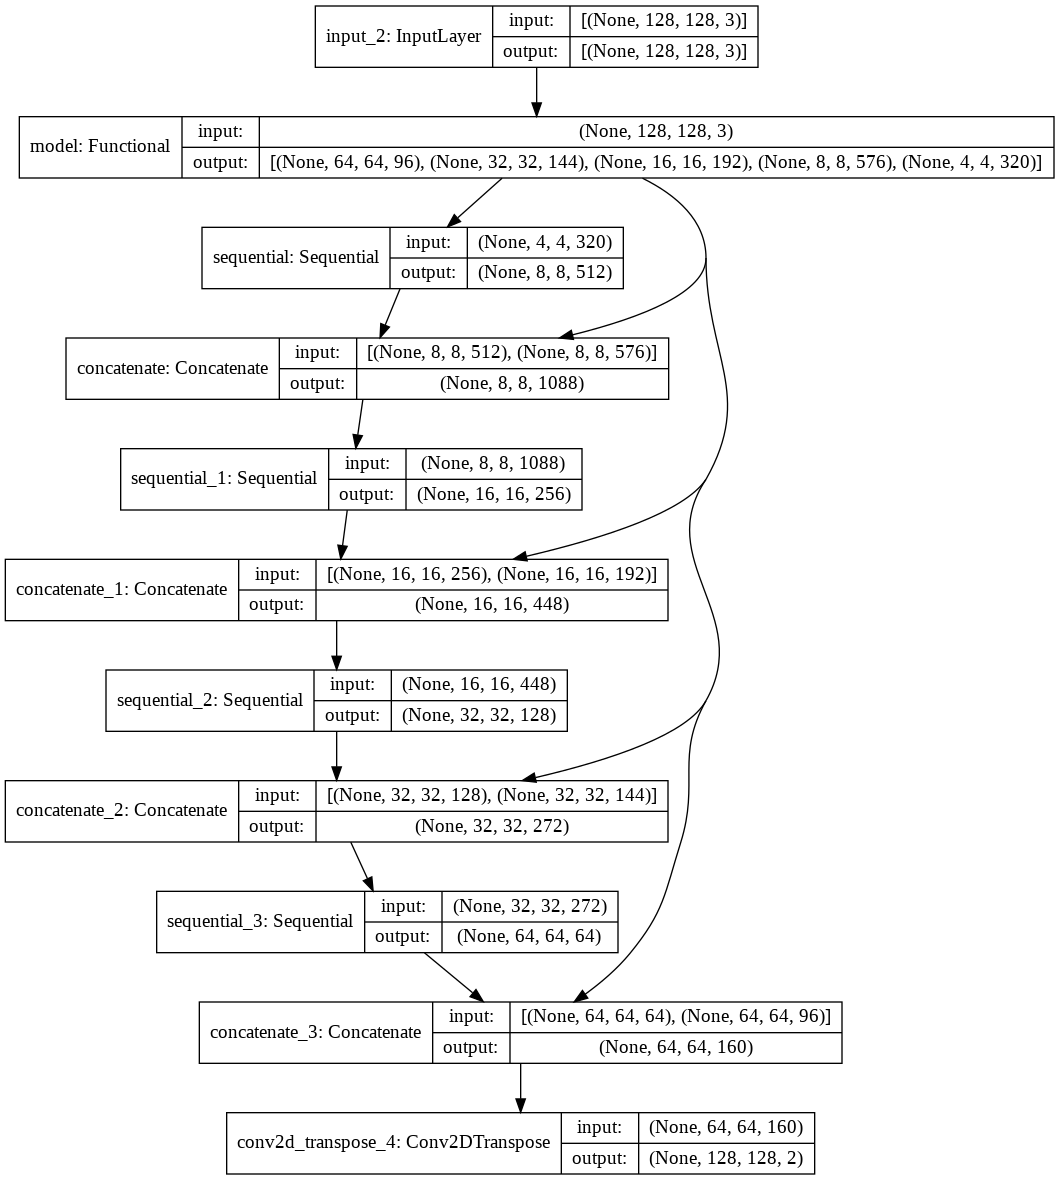

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

Vamos experimentar o modelo para ver o que ele prevê antes do treinamento.

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [18]:
def show_predictions(dataset=None, num=1):
  
    image, mask = val_gen.__getitem__(num)
    pred_mask = model.predict(image)
    i = random.randint(0,len(image)-1)
    display([image[i], mask[i], create_mask(pred_mask[i])])
  

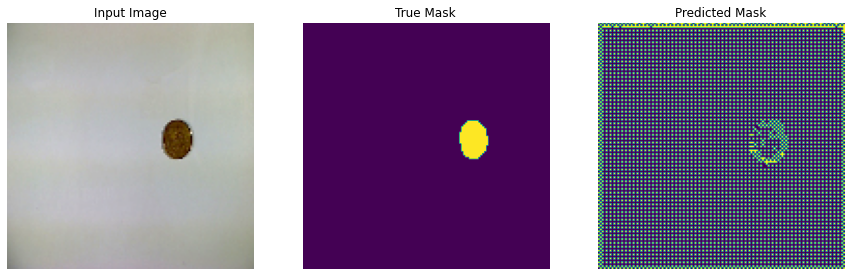

In [19]:
show_predictions(dataset=train_gen)

Vamos observar como o modelo melhora enquanto está treinando. Para realizar essa tarefa, uma função de retorno de chamada é definida abaixo.

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

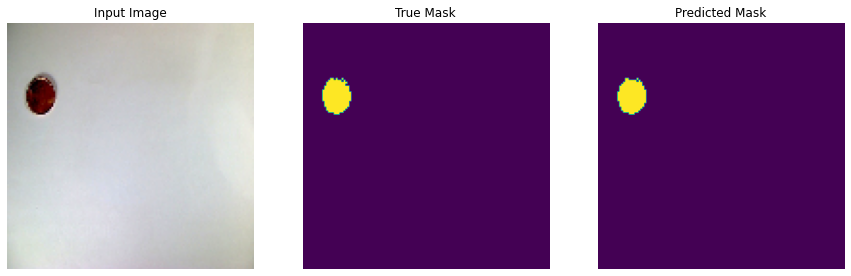


Sample Prediction after epoch 30



In [21]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = val_samples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = len(train_input_img_paths)//BATCH_SIZE
model_history = model.fit(train_gen, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_gen,
                          callbacks=[DisplayCallback()])

## Fazer Previsões

Vamos fazer algumas previsões. Com o objetivo de economizar tempo, o número de épocas foi pequeno, mas você pode definir isso mais alto para obter resultados mais precisos.

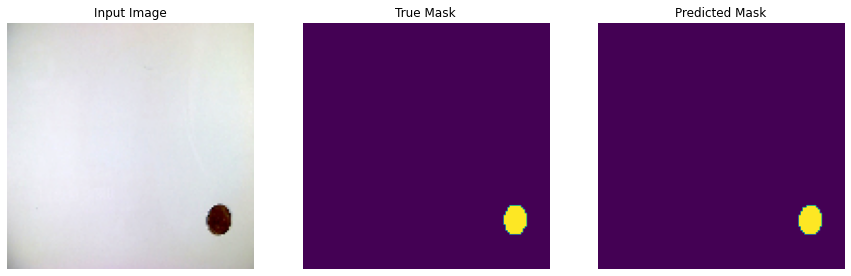

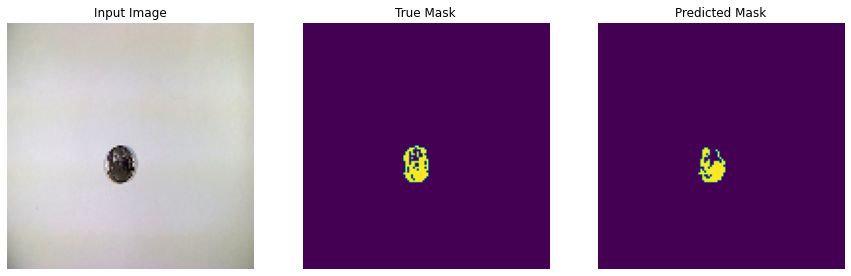

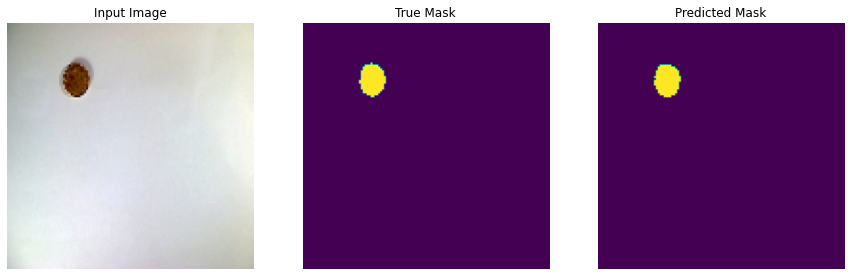

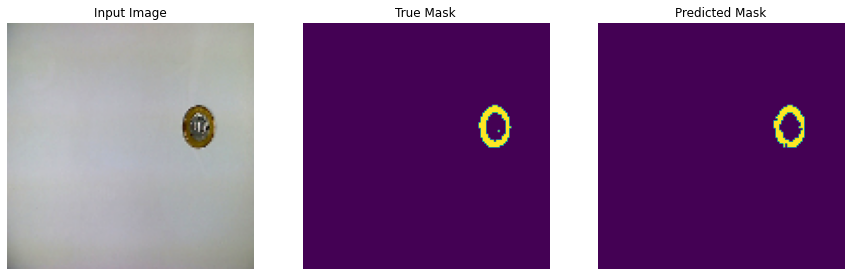

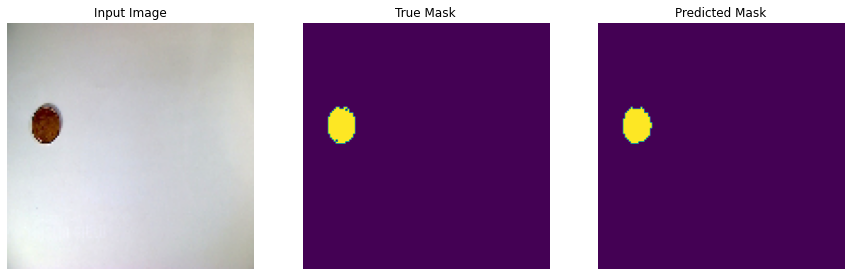

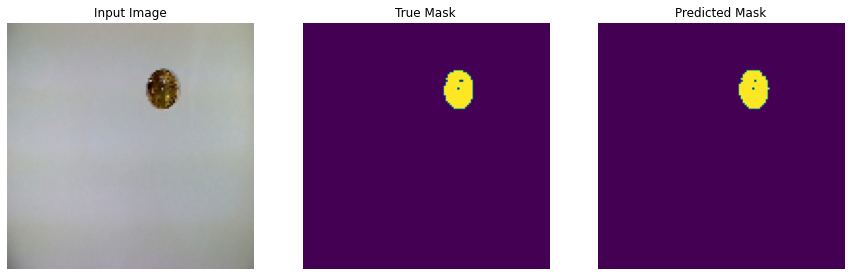

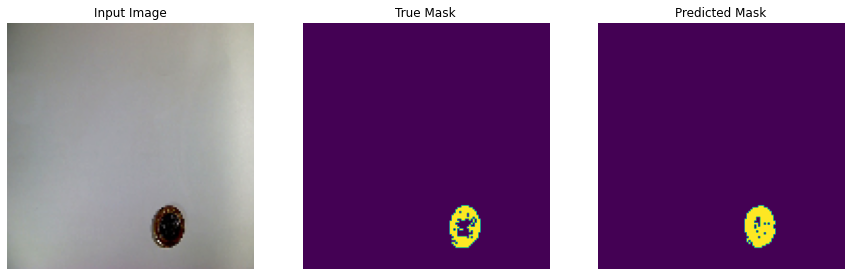

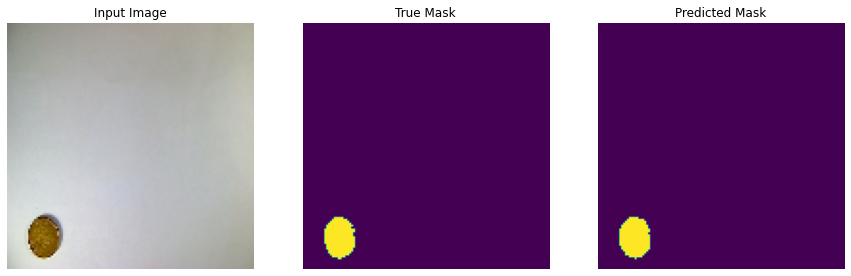

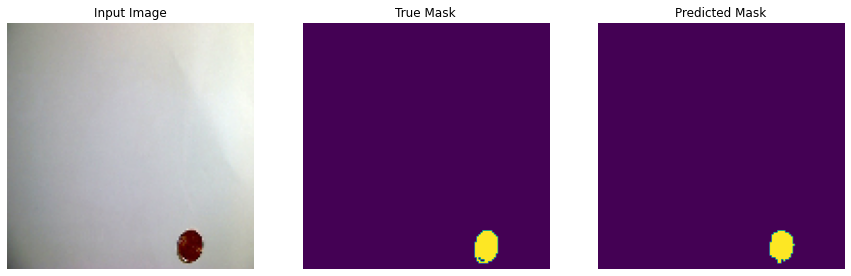

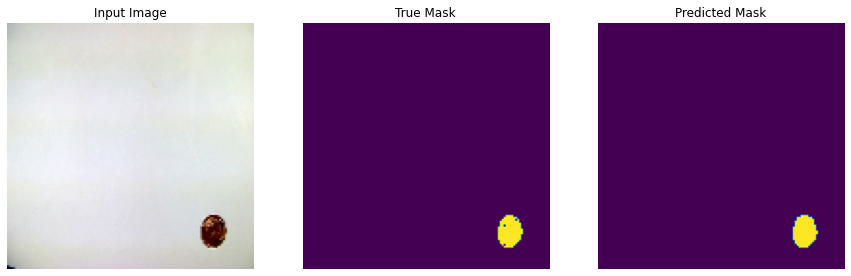

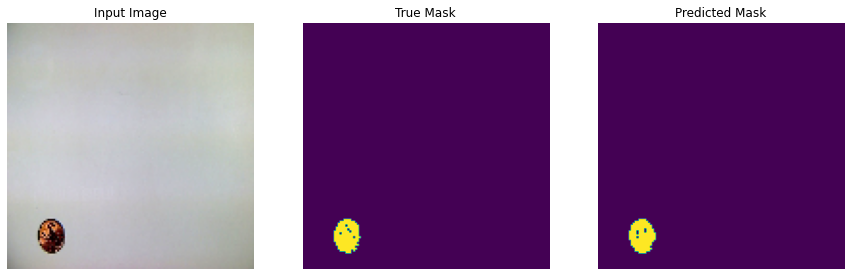

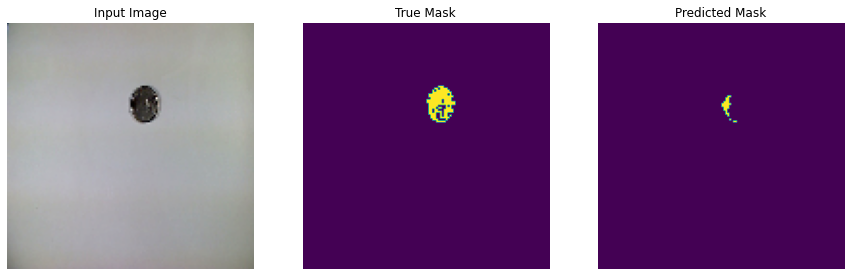

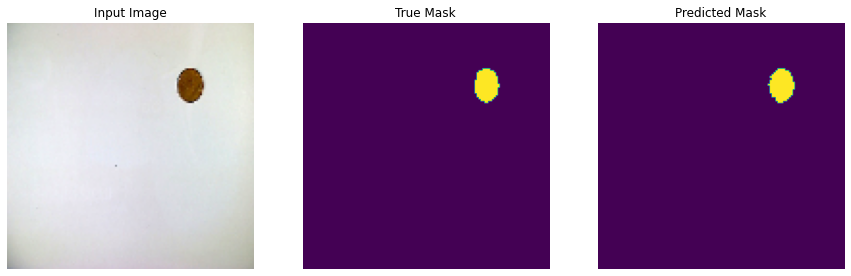

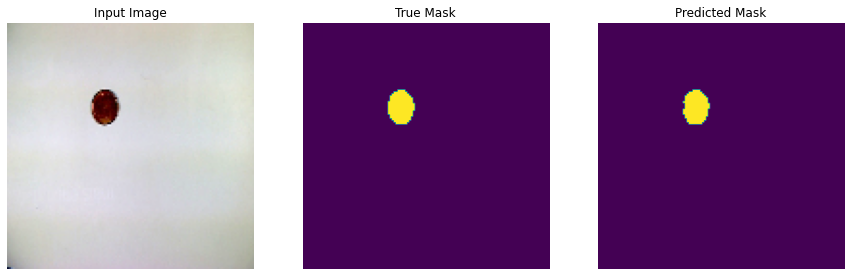

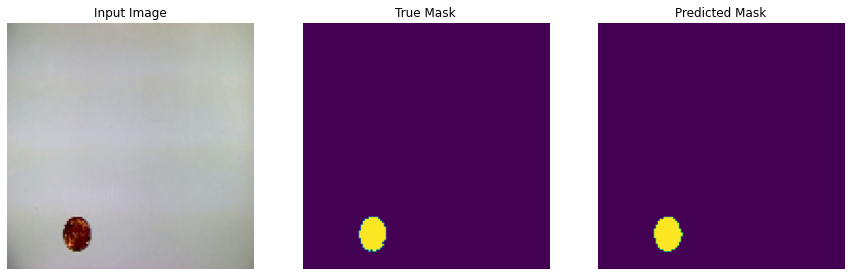

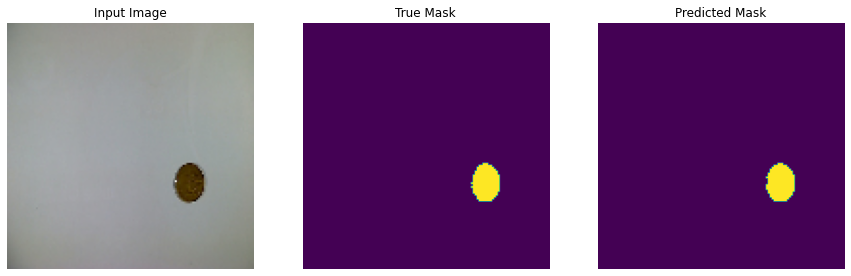

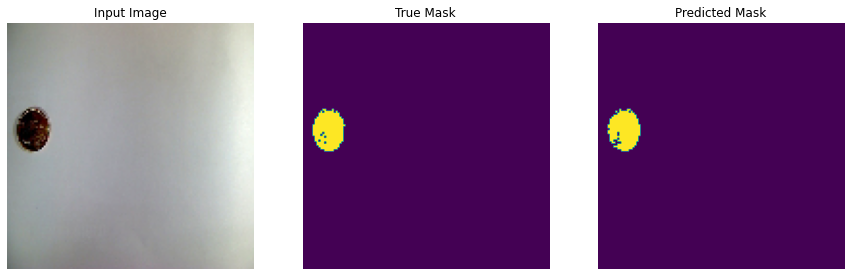

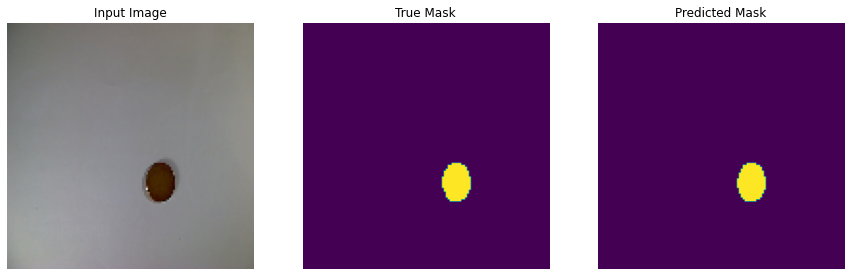

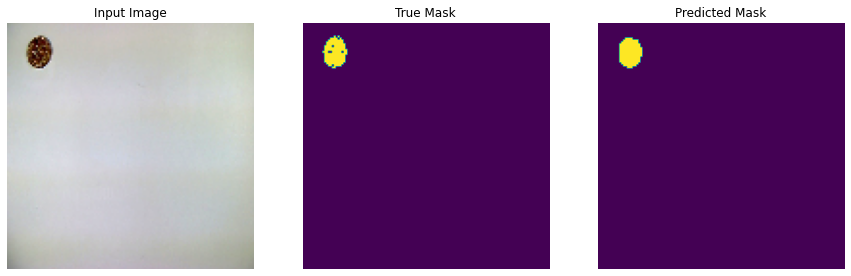

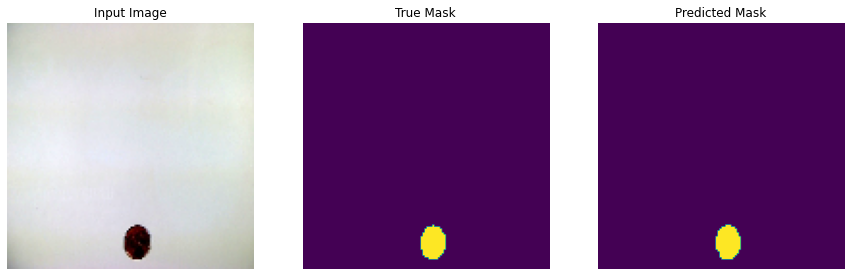

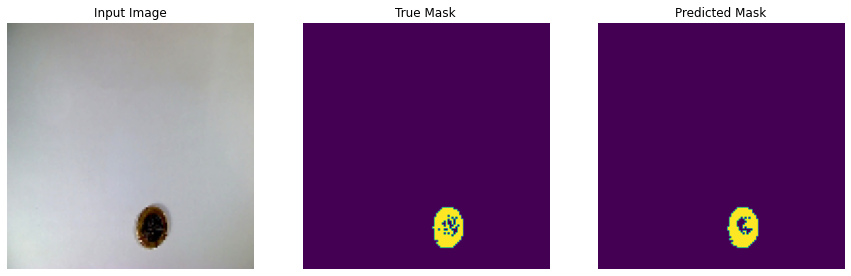

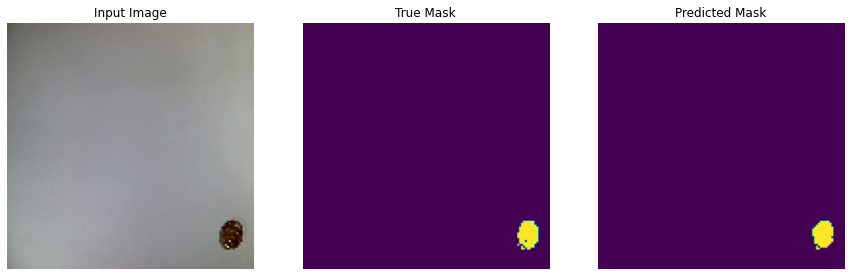

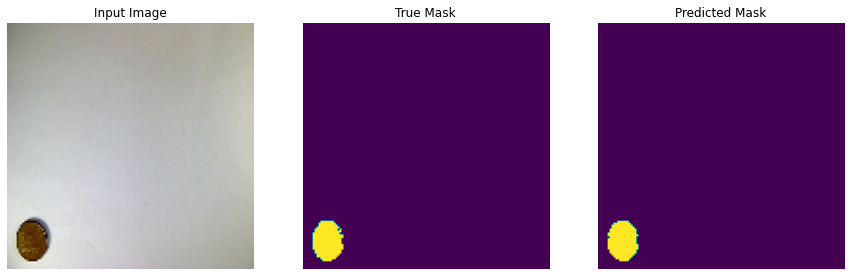

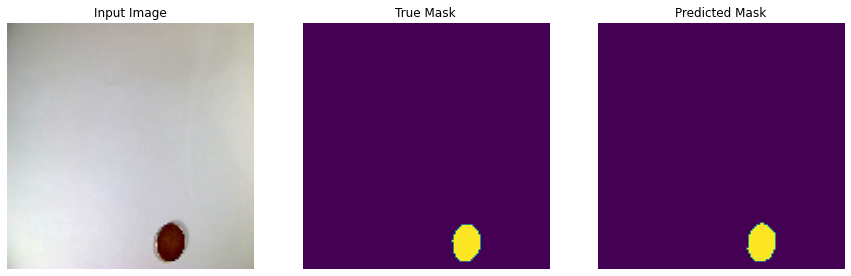

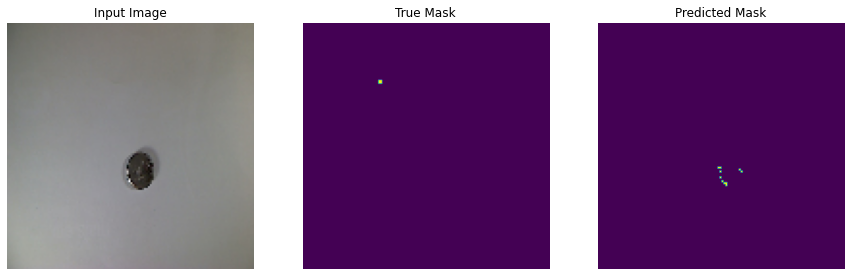

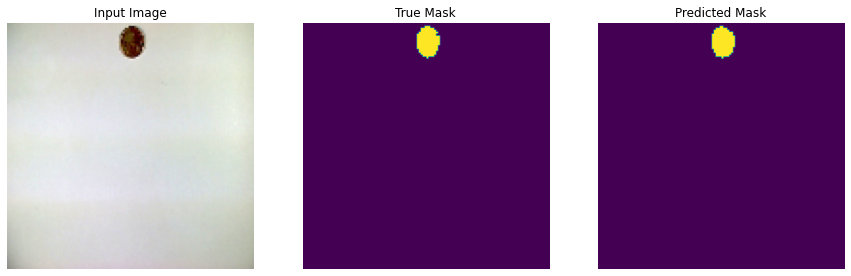

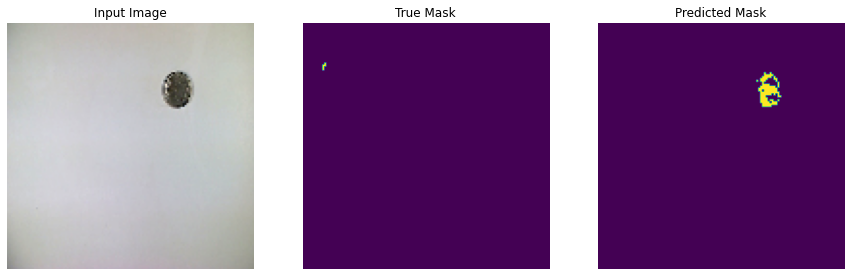

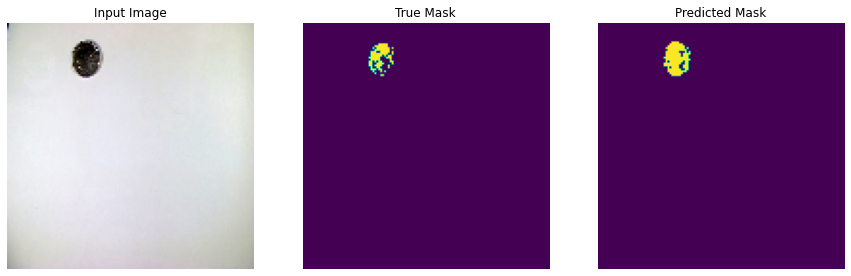

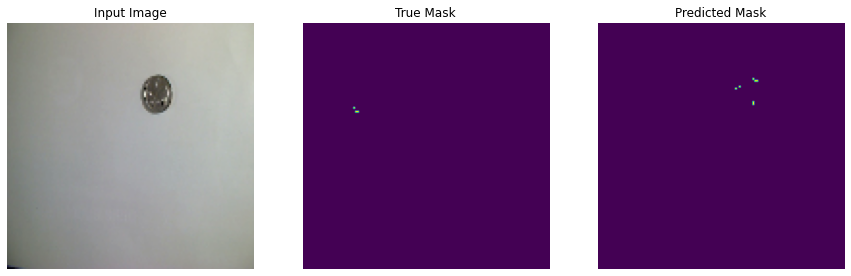

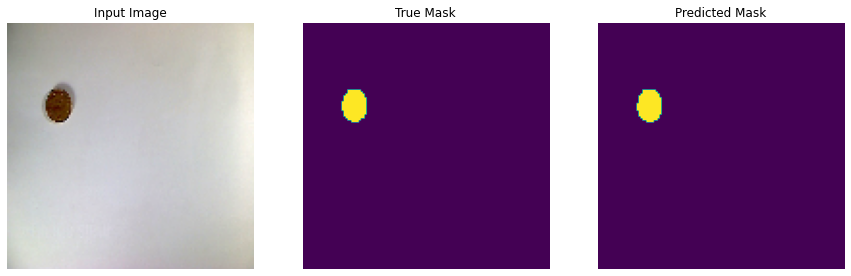

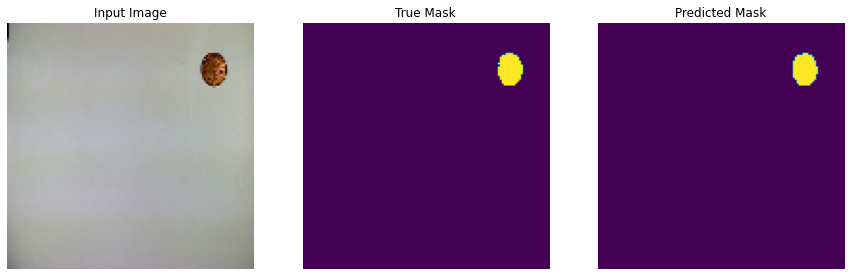

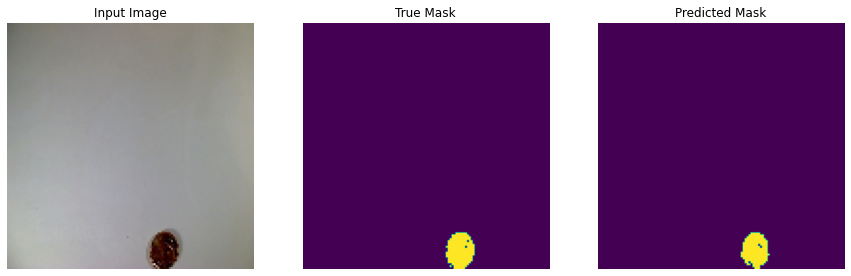

In [22]:
image, mask = val_gen.__getitem__(0)
pred_mask = model.predict(image)

for img,msk,pred in zip(image,mask,pred_mask):
    display([img, msk, create_mask(pred)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1] (128, 128, 1)


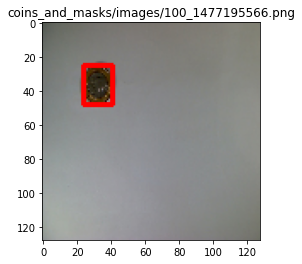

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1] (128, 128, 1)


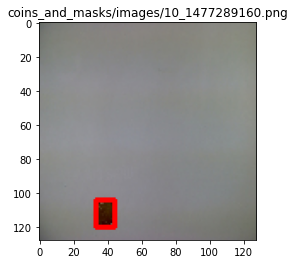

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1] (128, 128, 1)


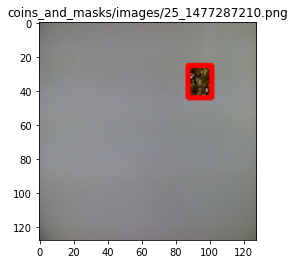

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1] (128, 128, 1)


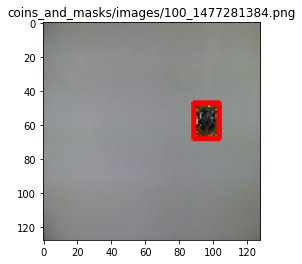

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1] (128, 128, 1)


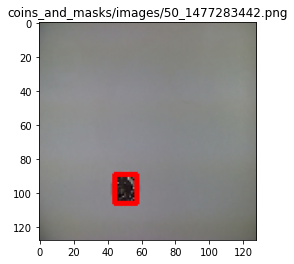

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1] (128, 128, 1)


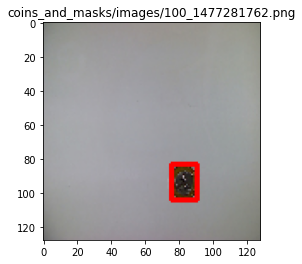

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1] (128, 128, 1)


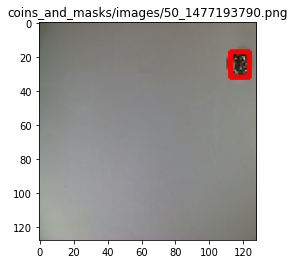

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1] (128, 128, 1)


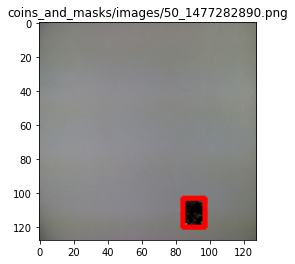

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1] (128, 128, 1)


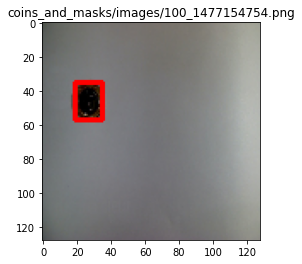

[0] (128, 128, 1)
Nao foi detectado bbox para  coins_and_masks/images/50_1477194234.png


In [23]:
#Aqui estou fazendo o predict da base inteira e defindo os bounding boxes
#Agora é so voce recortar a base e treina na sua CNN...ok!?

def bbox(img):
    a = np.where(img != 0)
    if a[0].shape[0] > 0 and a[1].shape[0] > 0:
        bbox = np.min(a[0]), np.max(a[0]), np.min(a[1]), np.max(a[1])
    else:
        bbox = None

    return bbox


imgs = []
pred = []
filenames = []

#Faco apenas para 10 imagens para ilustrar, mas é so alterar -> imgs_paths[:] se quiser a base toda
#Dica, comente os plots para agilizar quando processar toda a base
for path in imgs_paths[0:10]: 
    img = cv2.imread(path)/255.

    mask = model.predict(np.expand_dims(img,axis=0))  
    mask = create_mask(mask)  
    mask = np.squeeze(mask,axis=0)  
    
    print(np.unique(mask),mask.shape)

    rect = bbox(mask)  
    if rect is None:
        print("Nao foi detectado bbox para ", path)
        continue

    cv2.rectangle(img,(rect[2],rect[0]),(rect[3],rect[1]),(255,0,0),2)
    
    plt.title(path)
    plt.imshow(img)
    plt.show()
    

[0 1] (128, 128, 1)


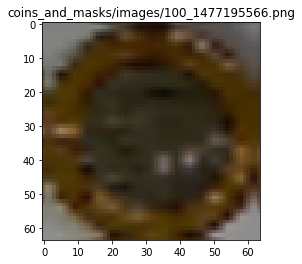

[0 1] (128, 128, 1)


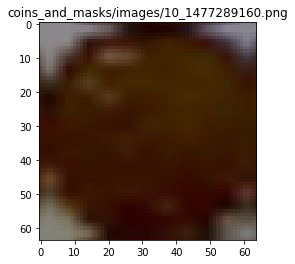

[0 1] (128, 128, 1)


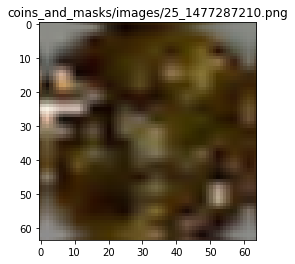

[0 1] (128, 128, 1)


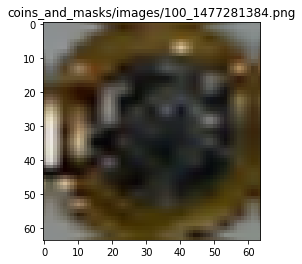

[0 1] (128, 128, 1)


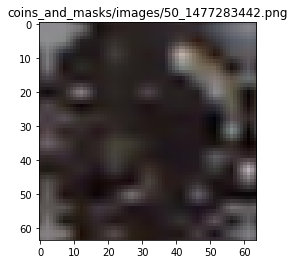

[0 1] (128, 128, 1)


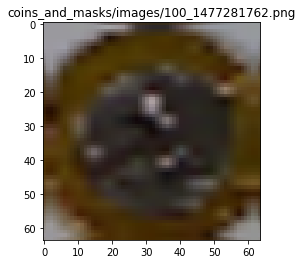

[0 1] (128, 128, 1)


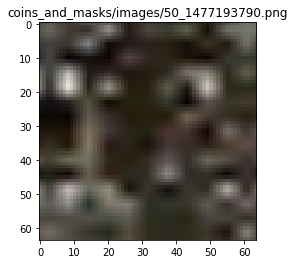

[0 1] (128, 128, 1)


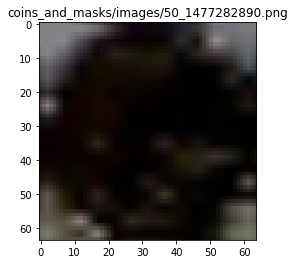

[0 1] (128, 128, 1)


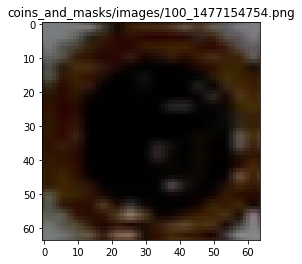

[0] (128, 128, 1)
Nao foi detectado bbox para  coins_and_masks/images/50_1477194234.png


In [24]:
for path in imgs_paths[0:10]: 
    img = cv2.imread(path)/255.

    mask = model.predict(np.expand_dims(img,axis=0))  
    mask = create_mask(mask)  
    mask = np.squeeze(mask,axis=0)  
    
    print(np.unique(mask),mask.shape)

    rect = bbox(mask)  
    if rect is None:
        print("Nao foi detectado bbox para ", path)
        continue

    #Recortando as imagens:
    cropped_image = img[rect[0]:rect[1], rect[2]:rect[3]]
  
    cropped_image = resize(cropped_image,(64, 64),
                       anti_aliasing=True)
    plt.title(path)
    plt.imshow(cropped_image)
    plt.show()

## Todas as moedas sem Bbox são moedas cinzas de 50 centavos que não possuem mascara!

Nao foi detectado bbox para  coins_and_masks/images/50_1477194234.png


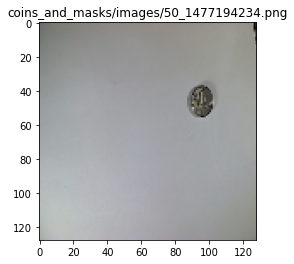

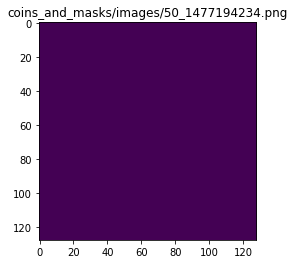

Nao foi detectado bbox para  coins_and_masks/images/50_1477193502.png


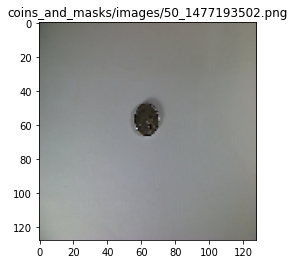

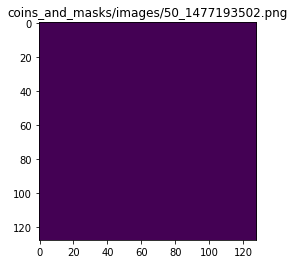

Nao foi detectado bbox para  coins_and_masks/images/50_1477194288.png


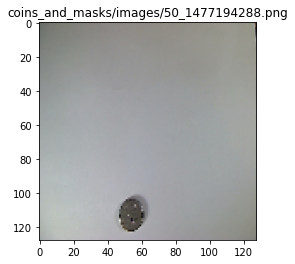

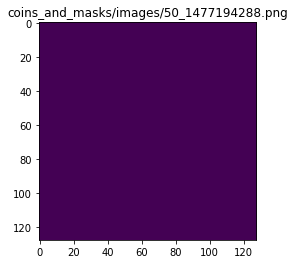

Nao foi detectado bbox para  coins_and_masks/images/50_1477194450.png


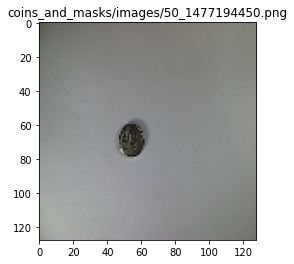

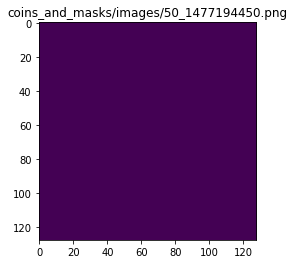

Nao foi detectado bbox para  coins_and_masks/images/50_1477282134.png


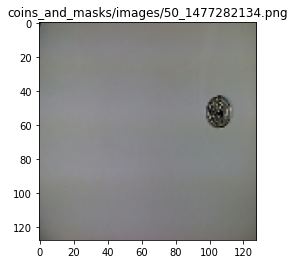

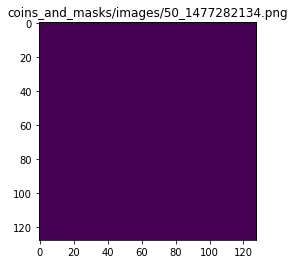

Nao foi detectado bbox para  coins_and_masks/images/50_1477283256.png


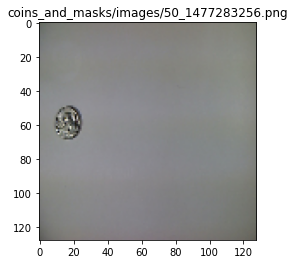

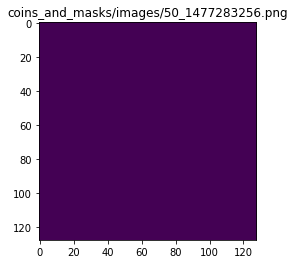

Nao foi detectado bbox para  coins_and_masks/images/50_1477283046.png


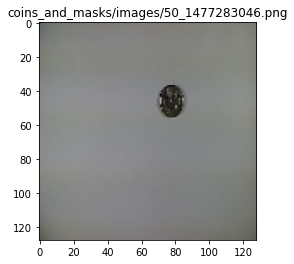

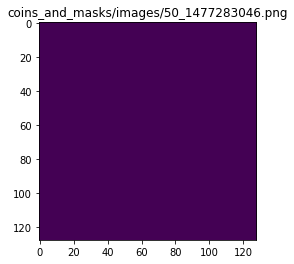

Nao foi detectado bbox para  coins_and_masks/images/50_1477283502.png


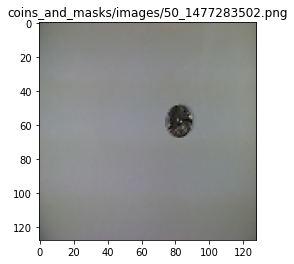

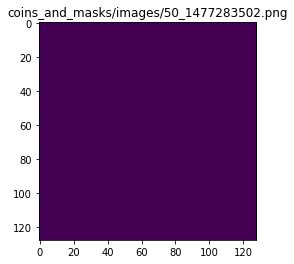

Nao foi detectado bbox para  coins_and_masks/images/50_1477282554.png


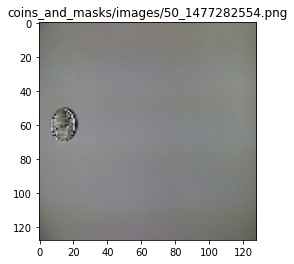

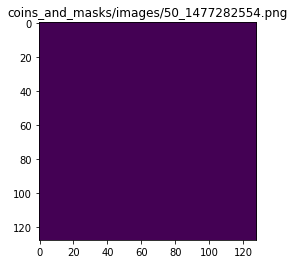

Nao foi detectado bbox para  coins_and_masks/images/50_1477193856.png


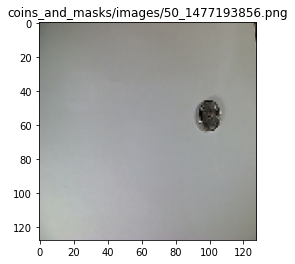

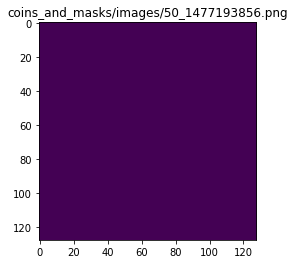

Nao foi detectado bbox para  coins_and_masks/images/50_1477282686.png


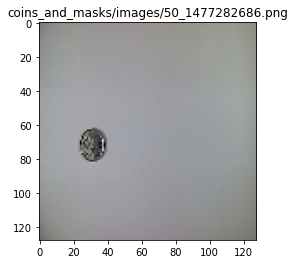

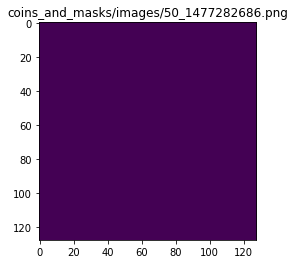

Nao foi detectado bbox para  coins_and_masks/images/50_1477193328.png


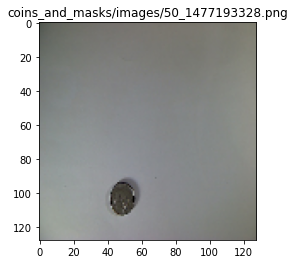

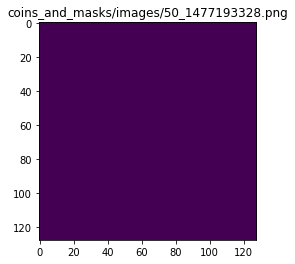

Nao foi detectado bbox para  coins_and_masks/images/50_1477282728.png


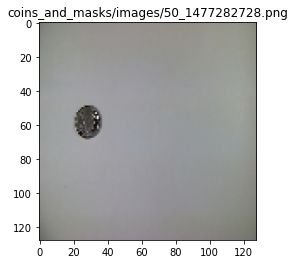

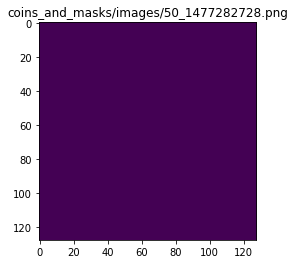

Nao foi detectado bbox para  coins_and_masks/images/50_1477282212.png


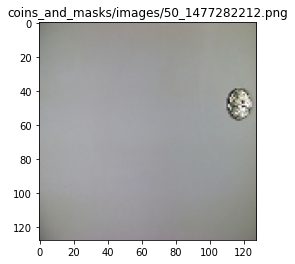

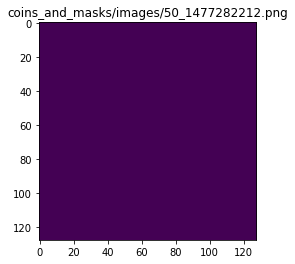

Nao foi detectado bbox para  coins_and_masks/images/50_1477282560.png


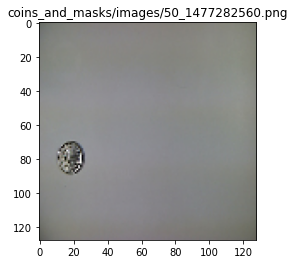

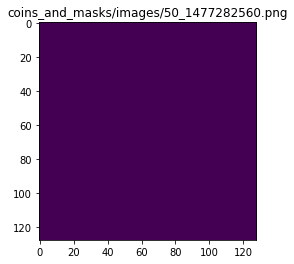

Nao foi detectado bbox para  coins_and_masks/images/50_1477144668.png


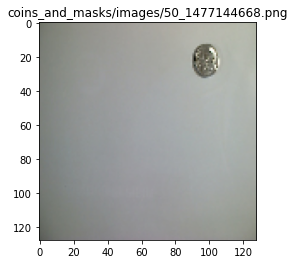

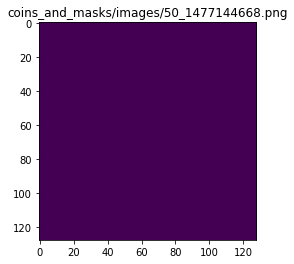

In [25]:
#Recortando para o dataset inteiro e salvando em lista:
cropped_images = []
coin_values = []
for path in imgs_paths: 
    img = cv2.imread(path)/255.

    mask = model.predict(np.expand_dims(img,axis=0))  
    mask = create_mask(mask)  
    mask = np.squeeze(mask,axis=0)  
    
    rect = bbox(mask)  
    if rect is None:
        print("Nao foi detectado bbox para ", path)
        plt.title(path)
        #mostra imagem
        plt.imshow(img)
        plt.show()
        plt.title(path)
        #mostra mascara
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
        plt.show()
        continue

    coin_value = path.split("_")[2].split("/")[-1]
    #Recortando as imagens:
    
    try:
      cropped_image = resize(img[rect[0]:rect[1], rect[2]:rect[3]],(64, 64), anti_aliasing=True)
      cropped_images.append(cropped_image)
      coin_values.append(coin_value)
    except:
      pass




# Classificação

## Split do Dataset

In [26]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix

In [27]:
from sklearn.model_selection import train_test_split

conversion = {'5':0, '10':1, '25':2, '50':3, '100':4}

X = cropped_images
y = [conversion[i] for i in coin_values]

X = np.array(X)
y = np.array(y)

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 stratify = y,
                                                 test_size = 0.3)

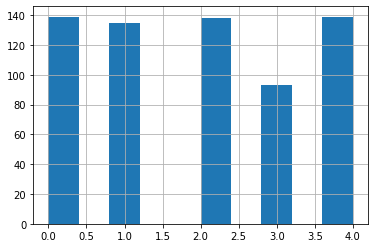

In [28]:
pd.DataFrame(y_train)[0].hist()

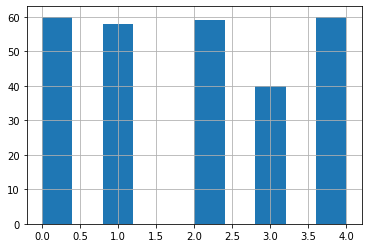

In [29]:
pd.DataFrame(y_test)[0].hist()

## CNN

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [31]:
model.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_test, y_test))

Epoch 1/20
21/21 [==============================] - 1s 35ms/step - loss: 1.5196 - accuracy: 0.3773 - val_loss: 1.0428 - val_accuracy: 0.5596
Epoch 2/20
21/21 [==============================] - 0s 15ms/step - loss: 0.8801 - accuracy: 0.6398 - val_loss: 0.8334 - val_accuracy: 0.6895
Epoch 3/20
21/21 [==============================] - 0s 15ms/step - loss: 0.6991 - accuracy: 0.7096 - val_loss: 0.6832 - val_accuracy: 0.7329
Epoch 4/20
21/21 [==============================] - 0s 16ms/step - loss: 0.6615 - accuracy: 0.7298 - val_loss: 0.6546 - val_accuracy: 0.7292
Epoch 5/20
21/21 [==============================] - 0s 14ms/step - loss: 0.5765 - accuracy: 0.7283 - val_loss: 0.6205 - val_accuracy: 0.7256
Epoch 6/20
21/21 [==============================] - 0s 14ms/step - loss: 0.5273 - accuracy: 0.7842 - val_loss: 0.6476 - val_accuracy: 0.7004
Epoch 7/20
21/21 [==============================] - 0s 14ms/step - loss: 0.4872 - accuracy: 0.8075 - val_loss: 0.6672 - val_accuracy: 0.7473
Epoch 8/20
21

9/9 - 0s - loss: 0.4320 - accuracy: 0.8881


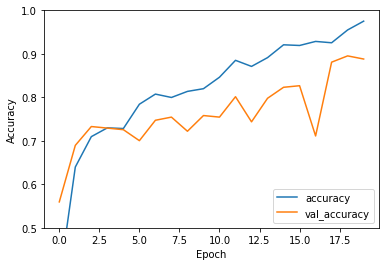

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

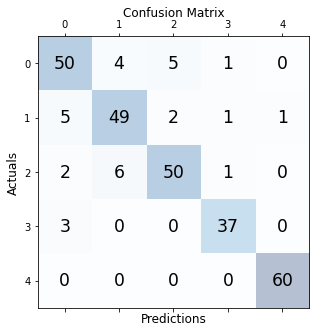

In [36]:
y_pred = model.predict(X_test,batch_size=32)
y_classes = y_pred.argmax(axis=-1)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_classes)

#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show()

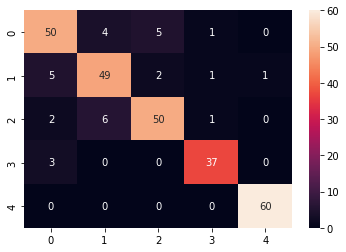

In [37]:
sns.heatmap(conf_matrix, annot=True)

## Lenet

In [38]:
lenet = models.Sequential()

lenet.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
lenet.add(layers.AveragePooling2D())

lenet.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
lenet.add(layers.AveragePooling2D())

lenet.add(layers.Flatten())

lenet.add(layers.Dense(units=120, activation='relu'))

lenet.add(layers.Dense(units=84, activation='relu'))

lenet.add(layers.Dense(units=10, activation = 'softmax'))

lenet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 6)         168       
_________________________________________________________________
average_pooling2d (AveragePo (None, 31, 31, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               376440    
_________________________________________________________________
dense_3 (Dense)              (None, 84)               

In [39]:
lenet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history_lenet = lenet.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_test, y_test))

Epoch 1/20
21/21 [==============================] - 1s 22ms/step - loss: 1.6553 - accuracy: 0.4161 - val_loss: 1.0262 - val_accuracy: 0.5451
Epoch 2/20
21/21 [==============================] - 0s 9ms/step - loss: 0.8474 - accuracy: 0.6832 - val_loss: 0.8318 - val_accuracy: 0.6931
Epoch 3/20
21/21 [==============================] - 0s 10ms/step - loss: 0.7337 - accuracy: 0.7096 - val_loss: 0.7584 - val_accuracy: 0.7220
Epoch 4/20
21/21 [==============================] - 0s 10ms/step - loss: 0.6848 - accuracy: 0.7050 - val_loss: 0.7246 - val_accuracy: 0.6679
Epoch 5/20
21/21 [==============================] - 0s 10ms/step - loss: 0.6288 - accuracy: 0.7220 - val_loss: 0.6664 - val_accuracy: 0.7690
Epoch 6/20
21/21 [==============================] - 0s 9ms/step - loss: 0.5421 - accuracy: 0.7826 - val_loss: 0.6373 - val_accuracy: 0.7437
Epoch 7/20
21/21 [==============================] - 0s 9ms/step - loss: 0.5498 - accuracy: 0.7593 - val_loss: 0.6310 - val_accuracy: 0.7762
Epoch 8/20
21/21

9/9 - 0s - loss: 0.9327 - accuracy: 0.7184


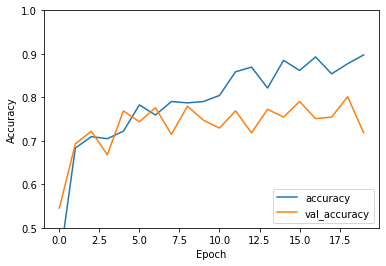

In [40]:
plt.plot(history_lenet.history['accuracy'], label='accuracy')
plt.plot(history_lenet.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = lenet.evaluate(X_test,  y_test, verbose=2)

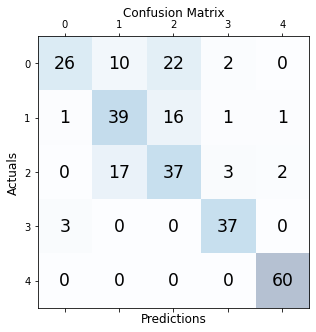

In [41]:
y_pred = lenet.predict(X_test,batch_size=32)
y_classes = y_pred.argmax(axis=-1)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_classes)

#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show()

In [42]:
y_pred

array([[9.3780527e-06, 5.9546930e-01, 4.0432659e-01, ..., 1.4692219e-09,
        2.2373986e-07, 6.5732837e-07],
       [2.3238881e-05, 4.7170123e-04, 2.7022319e-04, ..., 3.3086070e-07,
        9.7477269e-08, 4.6409167e-07],
       [3.5217899e-04, 7.3547316e-01, 2.6344258e-01, ..., 6.7183390e-07,
        1.5202506e-05, 2.9175691e-05],
       ...,
       [3.3330336e-06, 4.5581192e-01, 5.4415429e-01, ..., 3.4338735e-10,
        4.1285748e-08, 1.7233560e-07],
       [2.7922522e-03, 3.3215708e-01, 6.6192216e-01, ..., 2.1717397e-06,
        2.1072452e-05, 2.9805475e-05],
       [1.7083202e-01, 5.2709764e-01, 2.8678611e-01, ..., 8.1812505e-05,
        3.4090984e-04, 1.7979735e-04]], dtype=float32)

In [43]:
y_classes

array([1, 3, 1, 2, 3, 1, 3, 1, 1, 2, 1, 2, 4, 2, 2, 1, 2, 3, 4, 4, 3, 1,
       3, 2, 4, 1, 3, 1, 1, 1, 2, 1, 1, 3, 2, 3, 4, 3, 2, 1, 0, 3, 0, 4,
       4, 2, 1, 4, 4, 3, 2, 0, 4, 0, 4, 1, 4, 2, 1, 2, 0, 0, 1, 1, 2, 4,
       4, 2, 4, 2, 2, 2, 0, 0, 3, 4, 4, 2, 4, 3, 2, 2, 1, 1, 3, 2, 2, 2,
       4, 2, 2, 3, 4, 3, 3, 2, 0, 3, 2, 3, 4, 0, 1, 2, 4, 2, 1, 4, 2, 0,
       4, 1, 1, 4, 1, 3, 1, 4, 4, 0, 2, 3, 1, 4, 1, 4, 4, 0, 1, 4, 2, 4,
       2, 1, 2, 3, 1, 2, 0, 2, 1, 3, 2, 2, 4, 2, 1, 1, 3, 1, 3, 1, 2, 1,
       2, 4, 4, 0, 1, 2, 2, 2, 1, 0, 3, 3, 1, 1, 2, 3, 0, 2, 4, 0, 4, 2,
       2, 0, 4, 1, 4, 4, 2, 4, 1, 1, 4, 3, 3, 4, 0, 4, 0, 0, 4, 2, 3, 2,
       4, 1, 1, 1, 3, 3, 2, 1, 0, 4, 2, 2, 1, 4, 0, 1, 4, 2, 4, 4, 1, 0,
       2, 1, 0, 3, 4, 1, 1, 2, 4, 2, 3, 2, 2, 3, 3, 4, 4, 4, 1, 1, 2, 4,
       0, 1, 4, 2, 3, 0, 1, 4, 1, 1, 2, 4, 4, 4, 3, 0, 2, 2, 2, 1, 2, 2,
       3, 4, 3, 2, 0, 1, 2, 3, 1, 2, 2, 2, 1])

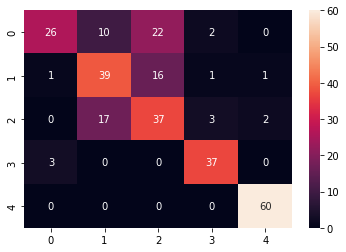

In [44]:
sns.heatmap(conf_matrix, annot=True)

## Alexnet

In [45]:
alexnet = models.Sequential()

alexnet.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(64,64,3)))

alexnet.add(layers.Conv2D(96, 11, strides=4, padding='same'))
alexnet.add(layers.Lambda(tf.nn.local_response_normalization))
alexnet.add(layers.Activation('relu'))
alexnet.add(layers.MaxPooling2D(3, strides=2))

alexnet.add(layers.Conv2D(256, 5, strides=4, padding='same'))
alexnet.add(layers.Lambda(tf.nn.local_response_normalization))
alexnet.add(layers.Activation('relu'))
alexnet.add(layers.MaxPooling2D(3, strides=2))

alexnet.add(layers.Conv2D(384, 3, strides=4, padding='same'))
alexnet.add(layers.Activation('relu'))

alexnet.add(layers.Conv2D(384, 3, strides=4, padding='same'))
alexnet.add(layers.Activation('relu'))

alexnet.add(layers.Conv2D(256, 3, strides=4, padding='same'))
alexnet.add(layers.Activation('relu'))

alexnet.add(layers.Flatten())
alexnet.add(layers.Dense(4096, activation='relu'))
alexnet.add(layers.Dropout(0.5))

alexnet.add(layers.Dense(4096, activation='relu'))
alexnet.add(layers.Dropout(0.5))

alexnet.add(layers.Dense(10, activation='softmax'))

alexnet.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
lambda (Lambda)              (None, 56, 56, 96)        0         
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 256)         614656    
_________________________________________________________________
lambda_1 (Lambda)            (None, 7, 7, 256)        

In [46]:
alexnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history_alexnet = alexnet.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_test, y_test))

Epoch 1/20
21/21 [==============================] - 4s 151ms/step - loss: 1.8293 - accuracy: 0.1925 - val_loss: 1.6239 - val_accuracy: 0.2166
Epoch 2/20
21/21 [==============================] - 3s 132ms/step - loss: 1.6096 - accuracy: 0.2158 - val_loss: 1.6011 - val_accuracy: 0.3249
Epoch 3/20
21/21 [==============================] - 3s 133ms/step - loss: 1.4747 - accuracy: 0.2780 - val_loss: 1.2559 - val_accuracy: 0.4224
Epoch 4/20
21/21 [==============================] - 3s 133ms/step - loss: 1.1946 - accuracy: 0.3960 - val_loss: 1.1158 - val_accuracy: 0.5199
Epoch 5/20
21/21 [==============================] - 3s 133ms/step - loss: 1.0443 - accuracy: 0.4845 - val_loss: 1.2211 - val_accuracy: 0.4440
Epoch 6/20
21/21 [==============================] - 3s 133ms/step - loss: 0.9119 - accuracy: 0.5823 - val_loss: 0.8272 - val_accuracy: 0.5596
Epoch 7/20
21/21 [==============================] - 3s 133ms/step - loss: 0.8462 - accuracy: 0.5776 - val_loss: 1.0447 - val_accuracy: 0.5307
Epoch 

9/9 - 0s - loss: 0.7040 - accuracy: 0.6859


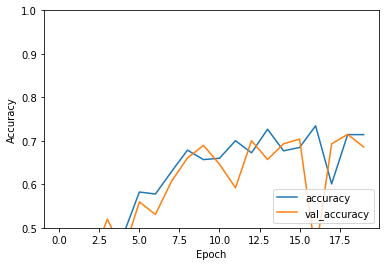

In [47]:
plt.plot(history_alexnet.history['accuracy'], label='accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = alexnet.evaluate(X_test,  y_test, verbose=2)

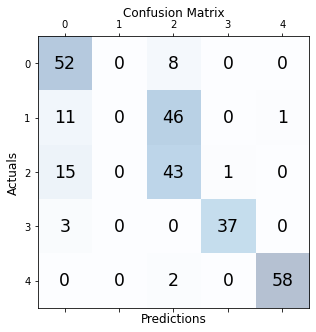

In [48]:
y_pred = alexnet.predict(X_test,batch_size=32)
y_classes = y_pred.argmax(axis=-1)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_classes)

#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show()

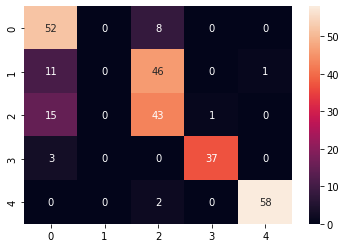

In [49]:
sns.heatmap(conf_matrix, annot=True)

## Conclusões

### CNN

O modelo CNN tem um bom desempenho, podendo chegar a 90% de acurácia após 20 epochs. O erro mais significativo para esse modelo parece ser uma confusão entre moedas de 10 e 25 centavos, que têm coloração semelhante.

### Lenet

Executando o modelo múltiplas vezes, percebe-se que o erro mais notável do mesmo é uma confusão entre moedas de 10 e 25 centavos, que têm coloração semelhante, assim como é o caso do CNN, mas com maior frequência. Sabendo que o modelo CNN não às confunde tão frequentemente, restaria então analisar quais operações geram esse erro para o modelo.

### Alexnet

A acurácia do modelo Alexnet deixa muito a desejar, muito provavelmente por uma adaptação não especializada para o problema em questão. Execuções repetidas do modelo não indicam um ponto específico de erro, como no caso do modelo Lenet, mas sim um comportamento vicioso do modelo de tentar "jogar" muitas das moedas para algumas poucas classes.